IMPORT DEPENDENCIES

In [32]:
# Library
import re
from unidecode import unidecode
import string
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from textblob import Word
import nltk
from nltk.tokenize import word_tokenize,MWETokenizer
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords as stopwords_scratch
from mpstemmer import MPStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from keras.models import load_model
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\L580\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\L580\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Dataset
df = pd.read_csv(r'D:\Data Science - Binar Academy Wave 2\PLATINUM\Challange\challenge_platinum\train_preprocess.tsv', sep='\t',names = ['data','label'],encoding='latin-1')
df

,data,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


Data Information

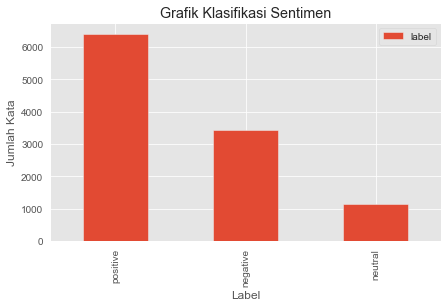

In [34]:
# Chart Klasifikasi Sentimen
df["label"].value_counts().plot.bar(figsize = (7, 4))
plt.title('Grafik Klasifikasi Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()

In [35]:
# Data Mapping
mapping = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}

df['kategori_label'] = df['label'].replace(mapping)
df['ln_text'] = df['data'].str.len()
df.head()

,data,label,kategori_label,ln_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,2,404
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,1,102
2,lokasi strategis di jalan sumatera bandung . t...,positive,2,184
3,betapa bahagia nya diri ini saat unboxing pake...,positive,2,93
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,0,214


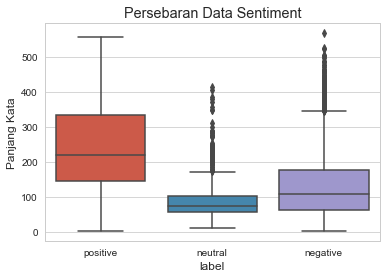

In [36]:
# Box Plot
sns.set_style('whitegrid')
sns.boxplot(y = df['ln_text'] , x = df['label']);
plt.ylabel('Panjang Kata')
plt.title('Persebaran Data Sentiment')
plt.show()

In [37]:
# Data Information
print(df['kategori_label'].describe(include=["all"]))

count    11000.000000
mean         1.270909
std          0.906818
min          0.000000
25%          0.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: kategori_label, dtype: float64


In [38]:
# Count Label
jumlah_data_per_label = df['label'].value_counts()
jumlah_data_per_label

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

Cleansing Data

In [39]:
# normalisasi kata alay pada text
df_alay = pd.read_csv(r'D:\Data Science - Binar Academy Wave 2\PLATINUM\Challange\challenge_platinum\DATA\new_kamusalay.csv', names=['alay','cleaned'], encoding ='latin-1')
df_alay

,alay,cleaned
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [40]:
# Stopwords
list_stopwords = stopwords_scratch.words('indonesian')
list_stopwords_en = stopwords_scratch.words('english')
list_stopwords.extend(list_stopwords_en)
list_stopwords.extend(['ya','yg','ga','yuk','dah','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'])

# External Stopwords
f = open("D:\Data Science - Binar Academy Wave 2\PLATINUM\Challange\challenge_platinum\delete_from_stopword.txt", "r")
stopword_external = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    stopword_external.append(line_list[0])
f.close()
list_stopwords.extend(stopword_external)

stopwords = list_stopwords

len(stopwords)

1002

In [41]:
# Function Cleansing Data
def lowercase(text): # Change uppercase characters to lowercase
    return text.lower()

def special(text): # Remove all the special characters
    text = re.sub(r'\W', ' ',str(text), flags=re.MULTILINE)
    return text

def single(text): # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def singlestart(text): # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def mulspace(text): # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    return text

def rt(text): # Remove RT
    text = re.sub(r'rt @\w+: ', ' ', text, flags=re.MULTILINE)
    return text

def prefixedb(text): # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text, flags=re.MULTILINE)
    return text

def misc(text): # Remove URL, Mention, Hashtag, user, Line, and Tab
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|([#@]\S+)|user|\n|\t', ' ', text, flags=re.MULTILINE)
    return text

alay_mapping = dict(zip(df_alay['alay'], df_alay['cleaned'])) # Mapping for kamusalay
def alay(text): # Remove by replacing 'alay' words
    wordlist = text.split()
    text_alay = [alay_mapping.get(x,x) for x in wordlist]
    clean_alay = ' '.join(text_alay)
    return clean_alay

def stopwrds(text): # Stopwords fuction
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords]
    output_sw = ' '.join(tokens_without_sw)
    return output_sw

# Function for text cleansing
def cleaning(text):
    text = lowercase(text)
    text = special(text)
    text = single(text)
    text = singlestart(text)
    text = mulspace(text)
    text = rt(text)
    text = prefixedb(text)
    text = misc(text)
    text = alay(text)
    text = stopwrds(text)
    return text

In [42]:
clean_text = df['data'].apply(lambda x: cleaning(x))
clean_text

0        warung dimiliki pengusaha pabrik puluhan terke...
1        mohon ulama lurus k212 mmbri hujjah partai diw...
2        lokasi strategis jalan sumatra bandung nya nya...
3        betapa bahagia nya unboxing paket barang nya b...
4        aduh mahasiswa sombong kasih kartu kuning bela...
                               ...                        
10995                                               kecewa
10996    enak masakan nya kepiting menyenangkan memilih...
10997                     hormati partai partai berkoalisi
10998      pagi pagi tol pasteur macet parah bikin jengkel
10999    belanja yogyakarta riau junction foodlife nya ...
Name: data, Length: 11000, dtype: object

In [43]:
# Encoded the target column
lb=LabelEncoder()
df["label"] = lb.fit_transform(df["label"])
df["label"]

0        2
1        1
2        2
3        2
4        0
        ..
10995    2
10996    2
10997    1
10998    0
10999    2
Name: label, Length: 11000, dtype: int32

In [44]:
# tokenizer
analisis = clean_text
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(analisis)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(analisis)
x = pad_sequences(encoded_docs, maxlen=200)

In [45]:
#Dump Tokenizer
joblib.dump(tokenizer,'tokenizer.pkl')

['tokenizer.pkl']

In [46]:
print(tokenizer.word_index)

{'nya': 1, 'enak': 2, 'makanan': 3, 'makan': 4, 'harga': 5, 'menu': 6, 'bandung': 7, 'banget': 8, 'restoran': 9, 'suasana': 10, 'malam': 11, 'nyaman': 12, 'jalan': 13, 'orang': 14, 'pelayanan': 15, 'ayam': 16, 'goreng': 17, 'suka': 18, 'bagus': 19, 'pemandangan': 20, 'nasi': 21, 'teman': 22, 'indonesia': 23, 'pilihan': 24, 'mahal': 25, 'sih': 26, 'lumayan': 27, 'kota': 28, 'cocok': 29, 'keluarga': 30, 'pas': 31, 'lokasi': 32, 'resto': 33, 'anak': 34, 'pesan': 35, 'porsi': 36, 'salah': 37, 'steak': 38, 'sunda': 39, 'minuman': 40, 'kafe': 41, 'khas': 42, 'rumah': 43, 'murah': 44, 'masakan': 45, 'mi': 46, 'ramah': 47, 'ramai': 48, 'bakso': 49, 'sambal': 50, 'oke': 51, 'favorit': 52, 'jam': 53, 'deh': 54, 'bakar': 55, 'menikmati': 56, 'mantap': 57, '2': 58, 'siang': 59, 'coba': 60, 'terjangkau': 61, 'partai': 62, 'mencoba': 63, 'daging': 64, '1': 65, 'bikin': 66, 'masuk': 67, 'luas': 68, 'cepat': 69, 'daerah': 70, 'memesan': 71, 'pedas': 72, 'jokowi': 73, 'pakai': 74, 'unik': 75, 'batagor'

In [47]:
print(x[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  120 2205 3276 2917 1080  132  385    7  540 1512 1284
 1512  120  185    6  239 2043  141    6   16  217   23    5   61  695
    1 

In [48]:
# evaluasi
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 32)           500416    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 60)                22320     
                                                                 
 dropout_6 (Dropout)         (None, 60)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 183       
                                                                 
Total params: 522,919
Trainable params: 522,919
Non-trainable params: 0
________________________________________________

In [49]:
#training
y=pd.get_dummies(df["label"])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [50]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nAkurasi telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [51]:
batch_size = 32
history = model.fit(X_train, y_train, epochs = 50, batch_size = batch_size, validation_split=0.3, callbacks=[callbacks])

Epoch 1/50
169/169 [==============================] - 56s 269ms/step - loss: 0.4803 - accuracy: 0.6479 - val_loss: 0.3623 - val_accuracy: 0.7615
Epoch 2/50
169/169 [==============================] - 36s 215ms/step - loss: 0.3523 - accuracy: 0.7699 - val_loss: 0.3123 - val_accuracy: 0.7922
Epoch 3/50
169/169 [==============================] - 42s 250ms/step - loss: 0.2877 - accuracy: 0.8056 - val_loss: 0.2679 - val_accuracy: 0.8030
Epoch 4/50
169/169 [==============================] - 44s 257ms/step - loss: 0.2270 - accuracy: 0.8601 - val_loss: 0.2389 - val_accuracy: 0.8489
Epoch 5/50
169/169 [==============================] - 44s 262ms/step - loss: 0.1773 - accuracy: 0.8974 - val_loss: 0.2458 - val_accuracy: 0.8619
Epoch 6/50
169/169 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9169
Akurasi telah mencapai nilai > 90%!
169/169 [==============================] - 47s 280ms/step - loss: 0.1489 - accuracy: 0.9169 - val_loss: 0.2517 - val_accuracy: 0.8519


In [52]:
model.evaluate(X_test,y_test)

104/104 [==============================] - 5s 48ms/step - loss: 0.2691 - accuracy: 0.8409


[0.26912808418273926, 0.8409090638160706]

In [53]:
#Save Model LSTM
model.save('model.h5')

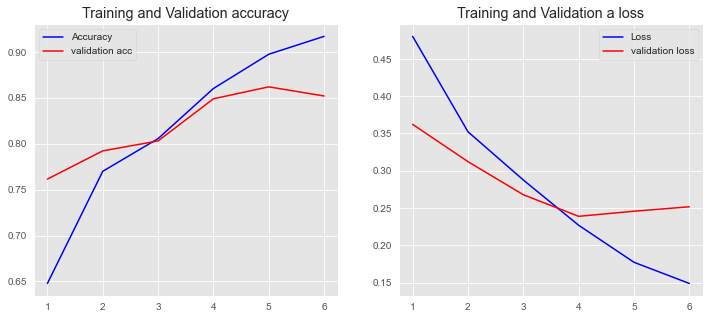

In [54]:
#mengukur hasil prediksi dan hasil loss
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc)+1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Accuracy')
  plt.plot(x, val_acc, 'r', label='validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()
  
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Loss')
  plt.plot(x, val_loss, 'r', label='validation loss')
  plt.title('Training and Validation a loss')
  plt.legend()

%matplotlib inline
plot_history(history)

In [55]:
def predict_sentiment(text):
    sentiment_tf = ['negative', 'neutral', 'positive']
    text = cleaning(text)
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen=x.shape[1])
    prediction = model.predict(tw)
    polarity = np.argmax(prediction[0])
    return sentiment_tf[polarity]

In [56]:
outputtf = predict_sentiment('bangsat')
print(outputtf)

1/1 [==============================] - 1s 725ms/step
negative


In [57]:
y_test = y_test.values
y_pred = model.predict(X_test)
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix_test)

104/104 [==============================] - 4s 36ms/step
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1031
           1       0.76      0.63      0.69       342
           2       0.89      0.90      0.90      1927

    accuracy                           0.84      3300
   macro avg       0.81      0.78      0.79      3300
weighted avg       0.84      0.84      0.84      3300



In [58]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

y = y.values

accuracies = []

for iteration, data in enumerate(kf.split(x), start=1):
  data_train = x[data[0]]
  target_train = y[data[0]]

  data_test = x[data[1]]
  target_test = y[data[1]]

  embedding_vector_length = 32
  model = Sequential() 
  model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
  model.add(SpatialDropout1D(0.25))
  model.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dropout(0.2))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  

  batch_size = 32
  history = model.fit(X_train, y_train, epochs = 50, batch_size = batch_size, validation_split=0.3, callbacks=[callbacks])

  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  print('Training no: ', iteration)
  print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
  print('=================================================================')

  accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Average Accuracy: ', average_accuracy)

Epoch 1/50
169/169 [==============================] - 54s 274ms/step - loss: 0.4828 - accuracy: 0.6584 - val_loss: 0.3526 - val_accuracy: 0.7628
Epoch 2/50
169/169 [==============================] - 45s 268ms/step - loss: 0.3423 - accuracy: 0.7737 - val_loss: 0.3028 - val_accuracy: 0.7913
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.8178